In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Content
* [Part0:Introduction](#section-one)
* [Part1:Data Preprocessing](#section-two)
    - [Import the Data and Necessary Libraries](#2.1)
    - [Checking the missing value](#2.2)
    - [Clean useless data](#2.3)
* [Part 2:EDA (Exploratory Data Analysis)](#3.1)
    - [Attrition analysis](#3.2)
* [Part 3:Feature Engineering](#4.1)
    - [Derive job hop index](#4.2)
* [Part 4:Predicting Employee Churn](#5.1)
    - [Split the data](#5.2)
    - [Dealing with multicollinearity](#5.3)
    - [Logistic Model](#5.4)
    - [Random Forest](#5.5)
    - [Decision Tree](#5.6)
    - [Draw the ROC curves using test sample](#5.7)
    - [Logistic Model is the Best](#5.8)
    - [89.12% Accuracy and 83% AUC!!!! ](#5.9)
* [Part 5:Designing retention strategy](#6.1)
    - [Know who may leave](#6.2)
    - [Creating turnover risk bucket](#6.3)
    - [Retention Strategy](#6.4)

<a id="section-one"></a>
# Part0:Introduction

Employee Attrition is when employees end their formal relationship with an organization. In other words, attrition is the gradual loss or withdrawal of employees from an organization over a period of time. Employees are arguably the most important asset of any organization, and one of the most critical issues facing organizations today is how to retain their employees. Nearly a quarter of U.S. workers quit each year, and in some industries, the turnover rate is much higher. According to a study by **SHRM (Society for Human Resource Management)**, the cost of replacing an employee is 50-60% of that employee's salary, with overall costs ranging from 90% to 200%. In this project, I will use **IBM HR Analytics Employee Attrition & Performance Data(https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?datasetId=1067&sortBy=voteCount&language=R)** to predict which employees are most likely to leave and use that information to design interventions to retain them.

<a id="section-two"></a>
# Part1:Data Preprocessing

<a id="2.1"></a>
## Import the Data and Necessary Libraries

In [ ]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(Information)
library(caret)
install.packages("car",lib='/kaggle/working')
library("car",lib="/kaggle/working")
library(fastDummies) 
library(rpart) #cart decision tree
library(ranger) #random forest
library(caret) #very useful tuning tool for machine learning models
library(MLmetrics) # compute performance measures such as AUC and MSE
library(plotROC) # ggplot for ROC/Gains

In [ ]:
library(caret)

In [ ]:
IBM <- read.csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
head(IBM)
glimpse(IBM)

<a id="2.2"></a>
## Checking the missing value

In [ ]:
# Checking the missing value
sapply(IBM, function(x) sum(is.na(x)))

<a id="2.3"></a>
## Clean useless data

We should drop the attributes EmployeeNumber, Over18, EmployeeCount and StandardHours,because they all carry the same value for each row

In [ ]:
#Drop EmployeeNumber, Over18, EmployeeCount and StandardHours
IBM$EmployeeCount <- NULL
IBM$Over18 <- NULL
IBM$StandardHours <- NULL
IBM$EmployeeNumber <-NULL
head(IBM)

<a id="3.1"></a>
# Part 2 :EDA (Exploratory Data Analysis)

In [ ]:
IBM %>%
  count(Attrition)

# Calculate turnover rate
IBM$Turnover <-ifelse(IBM$Attrition == 'Yes',1,0)

IBM %>%
summarize(Turnover_level = mean(Turnover))

<a id="3.2"></a>
## Attrition analysis

In [ ]:
fig <- function(w, h){
     options(repr.plot.width = w, repr.plot.height = h)
}
fig(19,10)
#Married with Turnover
IBM_Married <- IBM %>%
  group_by(MaritalStatus) %>%
  summarize(Turnover_level = mean(Turnover))

 M_T <- ggplot(IBM_Married, aes(x = MaritalStatus, y = Turnover_level,fill=MaritalStatus)) + 
  geom_col() +ggtitle("MaritalStatus&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobLevel with Turnover
IBM_level <- IBM %>%
  group_by(JobLevel) %>%
  summarize(Turnover_level = mean(Turnover))

Job_T <- ggplot(IBM_level, aes(x = JobLevel, y = Turnover_level,fill=JobLevel)) + 
  geom_col()+ggtitle("JobLevel&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Gender with Turnover
IBM_Gender <- IBM %>%
  group_by(Gender) %>%
  summarize(Turnover_level = mean(Turnover))

G_T <- ggplot(IBM_Gender, aes(x = Gender, y = Turnover_level,fill=Gender)) + 
  geom_col()+ggtitle("Gender&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Department with Turnover
IBM_Depart <- IBM %>%
  group_by(Department) %>%
  summarize(Turnover_level = mean(Turnover))

D_T <- ggplot(IBM_Depart, aes(x = Department, y = Turnover_level,fill=Department)) + 
  geom_col()+ggtitle("Department&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(M_T,Job_T,G_T,D_T, ncol = 2, nrow = 2)

In [ ]:
#EnvironmentSatisfaction with Turnover
IBM_EnvironmentSatisfaction <- IBM %>%
  group_by(EnvironmentSatisfaction) %>%
  summarize(Turnover_level = mean(Turnover))

 EnvironmentSatisfaction_T <- ggplot(IBM_EnvironmentSatisfaction, aes(x = EnvironmentSatisfaction, y = Turnover_level,fill=EnvironmentSatisfaction)) + 
  geom_col() +ggtitle("EnvironmentSatisfaction&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobInvolvement with Turnover
IBM_JobInvolvement <- IBM %>%
  group_by(JobInvolvement) %>%
  summarize(Turnover_level = mean(Turnover))

JobInvolvement_T <- ggplot(IBM_JobInvolvement, aes(x = JobInvolvement, y = Turnover_level,fill=JobInvolvement)) + 
  geom_col()+ggtitle("JobInvolvement&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#JobRole with Turnover
IBM_JobRole <- IBM %>%
  group_by(JobRole) %>%
  summarize(Turnover_level = mean(Turnover))

JobRole_T <- ggplot(IBM_JobRole, aes(x = JobRole, y = Turnover_level,fill=JobRole)) + 
  geom_col()+ggtitle("JobRole&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))
#Department with Turnover
IBM_JobSatisfaction <- IBM %>%
  group_by(JobSatisfaction) %>%
  summarize(Turnover_level = mean(Turnover))

JobSatisfaction_T <- ggplot(IBM_JobSatisfaction, aes(x = JobSatisfaction, y = Turnover_level,fill=JobSatisfaction)) + 
  geom_col()+ggtitle("JobSatisfaction&Turnover") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(EnvironmentSatisfaction_T,JobInvolvement_T,JobRole_T ,JobSatisfaction_T, ncol = 2, nrow = 2)

In [ ]:
fig(19,10)
#MonthlyIncome with Attrition
 M_A <- ggplot(IBM, aes(x = Attrition, y = MonthlyIncome,fill=Attrition)) + 
  geom_boxplot() +ggtitle("MonthlyIncome&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

#DistanceFromHome with Attrition
 M_D <- ggplot(IBM, aes(x = Attrition, y = DistanceFromHome,fill=Attrition)) + 
  geom_boxplot() +ggtitle("DistanceFromHome&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))


grid.arrange(M_A,M_D, ncol = 2, nrow = 1)

In [ ]:
fig(19,10)
#PercentSalaryHike with Attrition
 A <- ggplot(IBM, aes(x = Attrition, y = PercentSalaryHike,fill=Attrition)) + 
  geom_boxplot() +ggtitle("PercentSalaryHike&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

#YearsAtCompany with Attrition
 B <- ggplot(IBM, aes(x = Attrition, y = YearsAtCompany,fill=Attrition)) + 
  geom_boxplot() +ggtitle("YearsAtCompany&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

 C <- ggplot(IBM, aes(x = Attrition, y = YearsSinceLastPromotion,fill=Attrition)) + 
  geom_boxplot() +ggtitle("YearsSinceLastPromotion&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

D <- ggplot(IBM, aes(x = Attrition, y = TrainingTimesLastYear,fill=Attrition)) + 
  geom_boxplot() +ggtitle("TrainingTimesLastYear&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

grid.arrange(A,B,C,D, ncol = 2, nrow = 2)

<a id="4.1"></a>
# Feature Engineering

<a id="4.2"></a>
## Derive job hop index
A job hopper is a person who switches jobs frequently for financial or career advancement opportunities. In some industries, recruiters and hiring managers may perceive job hoppers in a negative light and think they are unstable or disloyal employees.

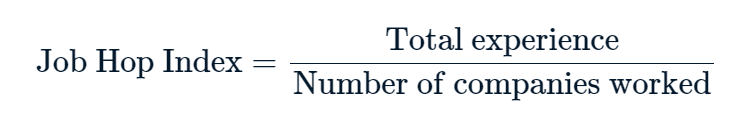

Total experience **(TotalWorkingYears**) and the number of companies worked (**NumCompaniesWorked+1**) are available in IBM.

In [ ]:
fig(12,8)
# Add job hop index
IBM$job_hop_index <- IBM$TotalWorkingYears/(IBM$NumCompaniesWorked+1)

# Compare job hopping index with Attrition
ggplot(IBM, aes(x = Attrition, y = job_hop_index,fill=Attrition)) + 
  geom_boxplot()+ggtitle("Job_hop_index&Attrition") + 
theme(plot.title = element_text(size = 20, face = "bold"))

In [ ]:
# Changing the datatype from integer to factors from the ordinal variables.

IBM$Education <- factor(IBM$Education)
IBM$EnvironmentSatisfaction <- factor(IBM$EnvironmentSatisfaction)
IBM$JobInvolvement <- factor(IBM$JobInvolvement)
IBM$JobLevel <- factor(IBM$JobLevel)
IBM$JobSatisfaction <- factor(IBM$JobSatisfaction)
IBM$PerformanceRating <- factor(IBM$PerformanceRating)
IBM$RelationshipSatisfaction <- factor(IBM$RelationshipSatisfaction)
IBM$StockOptionLevel <- factor(IBM$StockOptionLevel)
IBM$WorkLifeBalance <- factor(IBM$WorkLifeBalance)

In [ ]:
glimpse(IBM)

<a id="5.1"></a>
# Predicting Employee Churn

<a id="5.2"></a>
## Split the data

In [ ]:
set.seed(1)

# Store row numbers for training dataset: index_train
IBM_train <- createDataPartition(IBM$Turnover, p = 0.7, list = FALSE)

# Create training dataset: train_set
train_set <- IBM[IBM_train, ]

# Create testing dataset: test_set
test_set <- IBM[-IBM_train, ]

In [ ]:
train_set$Attrition <- NULL
train_set$TotalWorkingYears <- NULL
train_set$NumCompaniesWorked <- NULL

In [ ]:
# Calculate turnover proportion in train_set
train_set %>% 
  count(Turnover) %>% 
  mutate(prop = n / sum(n))

# Calculate turnover proportion in test_set
test_set %>% 
  count(Turnover) %>% 
  mutate(prop = n / sum(n))

<a id="5.3"></a>
## Dealing with multicollinearity
In the previous exercise, you found that multicollinearity exists in your model by reviewing the VIF values of independent variables. Follow the steps below to remove multicollinearity:

* Step 1: Calculate VIF of the model
* Step 2: Identify if any variable has VIF greater than or equal to 5
* Step 2a: Remove the variable from the model if it has a VIF greater than or equal to 5
* Step 2b: If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF
* Step 3: Repeat steps 1 and 2 until VIF of all variables is less than 5

In [ ]:
glimpse(train_set)

In [ ]:
logmodel <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
summary(logmodel)

In [ ]:
print(vif(logmodel))

In [ ]:
train_set <- subset(train_set, select = - c(Department))
test_set <- subset(test_set, select = - c(Department))

In [ ]:
logmodel1 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel1))

In [ ]:
train_set <- subset(train_set, select = - c(JobRole))
test_set <- subset(test_set, select = - c(JobRole))

In [ ]:
logmodel2 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel2))

In [ ]:
train_set <- subset(train_set, select = - c(JobLevel))
test_set <- subset(test_set, select = - c(JobLevel))

In [ ]:
logmodel3 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel3))

In [ ]:
train_set <- subset(train_set, select = - c(YearsAtCompany))
test_set <- subset(test_set, select = - c(YearsAtCompany))

<a id="5.4"></a>
## Logistic Model

In [ ]:
logmodel4 <- glm(Turnover ~., family=binomial(link="logit"), data = train_set)
print(vif(logmodel4))

In [ ]:
summary(logmodel4)

In [ ]:
prediction_test <- predict(logmodel4, newdata = test_set, 
                            type = "response")

<a id="5.5"></a>
## Random forest 

In [ ]:
ranger.caret <- train(as.factor(Turnover) ~.,
                        data = train_set, method="ranger", 
                       trControl = trainControl(method = "cv", number = 10))
ranger.caret

In [ ]:
IBM.ranger <- ranger(as.factor(Turnover) ~.,data = train_set, probability = TRUE, mtry = 24, splitrule = "gini", min.node.size = 1)

In [ ]:
ranger.predict.train <- predict(IBM.ranger, data = train_set, type = "response")
ranger.predict.test <- predict(IBM.ranger, data = test_set, type = "response")
# AUC
AUC(ranger.predict.test$predictions[,2], test_set$Turnover)

<a id="5.6"></a>
## Decision Tree

In [ ]:
cart.caret <- train(as.factor(Turnover) ~ .,
                        data = train_set, method="rpart",
                       trControl = trainControl(method = "cv", number = 10))
cart.caret

In [ ]:
IBM.cart <- rpart(Turnover ~.,
                       method="class",
                       data = train_set, 
                       control = rpart.control(cp = 0.02694611))

cart.predict.train <- predict(IBM.cart, newdata = train_set)
cart.predict.test <- predict(IBM.cart, newdata = test_set)

# AUC for test sample
AUC(cart.predict.test[,2], test_set$Turnover)

<a id="5.7"></a>
## Draw the ROC curves using test sample

In [ ]:
plotdata.test <- data.frame(cbind(test_set$Turnover,
                                   prediction_test,
                                   cart.predict.test[,2],
                                   ranger.predict.test$predictions[,2]))
names(plotdata.test) <- c("Turnover", "Logit", "CART", "RF")

comparison.plot <- ggplot(plotdata.test, aes(m = Logit, d = Turnover))+ 
  geom_roc(labels=FALSE, aes(color = 'Logit_Test')) +
  labs(x = "Cum. Customers", y = "Cum. Gains") + geom_abline() +
  scale_color_discrete(name = 'Model') +
  geom_roc(data = plotdata.test, labels = FALSE, aes(m = CART, d = Turnover, color = 'CART_Test')) +
  geom_roc(data = plotdata.test, labels = FALSE, aes(m = RF, d = Turnover, color = 'RF_Test'))
comparison.plot

<a id="5.8"></a>
## Logistic Model is the Best

In [ ]:
prediction_categories <- ifelse(prediction_test >= 0.50, 1, 0)

# Construct a confusion matrix
conf_matrix <- table(prediction_categories, test_set$Turnover)
conf_matrix

<a id="5.9"></a>
## 89.12% Accuracy and 83% AUC!!!! 

In [ ]:
accuracy <- (363+30)/(363+30+40+8)
AUC(prediction_test,test_set$Turnover)
accuracy

<a id="6.1"></a>
# Designing retention strategy

<a id="6.2"></a>
## Know who may leave

In [ ]:
# Calculate probability of turnover
IBM_Pre <- read.csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
IBM_Pre$job_hop_index <- IBM_Pre$TotalWorkingYears/(IBM_Pre$NumCompaniesWorked+1)


In [ ]:
IBM_Pre$Education <- factor(IBM_Pre$Education)
IBM_Pre$EnvironmentSatisfaction <- factor(IBM_Pre$EnvironmentSatisfaction)
IBM_Pre$JobInvolvement <- factor(IBM_Pre$JobInvolvement)
IBM_Pre$JobLevel <- factor(IBM_Pre$JobLevel)
IBM_Pre$JobSatisfaction <- factor(IBM_Pre$JobSatisfaction)
IBM_Pre$PerformanceRating <- factor(IBM_Pre$PerformanceRating)
IBM_Pre$RelationshipSatisfaction <- factor(IBM_Pre$RelationshipSatisfaction)
IBM_Pre$StockOptionLevel <- factor(IBM_Pre$StockOptionLevel)
IBM_Pre$WorkLifeBalance <- factor(IBM_Pre$WorkLifeBalance)

In [ ]:
IBM_NO <- IBM_Pre %>%
  filter(Attrition == "No")

In [ ]:
emp_risk <- predict(logmodel4, newdata =IBM_NO, 
                            type = "response")
IBM_NO$emp_risk <- emp_risk

In [ ]:
IBM_NO %>% 
  select(EmployeeNumber, emp_risk) %>% 
  top_n(2)

<a id="6.3"></a>
## Creating turnover risk bucket
* no-risk, if 0 <= fit <= 0.5
* low-risk, if 0.5 < fit <= 0.6
* medium-risk, if 0.6 < fit <= 0.8
* high-risk, if 0.8 < fit <= 1

In [ ]:
# Create turnover risk buckets
emp_risk_bucket <- IBM_NO %>% 
  mutate(risk_bucket = cut(emp_risk, breaks = c(0, 0.5, 0.6, 0.8, 1), 
                           labels = c("no-risk", "low-risk", 
                                      "medium-risk", "high-risk")))

# Count employees in each risk bucket
emp_risk_bucket %>% 
  count(risk_bucket)

<a id="6.4"></a>
## Rention strategy

As an HR professional, you will work with the management team to come up with an action plan and hold conversations to understand the engagement level of the employee, identify issues and concerns which require immediate action. Similarly, for medium-risk employees, you can track behavioral changes and schedule discussions which can be an open house or one-on-ones.For all employees in the low-risk bucket, you can understand employees concerns by an open house discussion, after that create an action plan and bring their concerns to closure. For employees in the no-risk bucket, there is no action required on an immediate basis. Of course, these were just some suggestions and depending on your organization, you can come up with several other strategies.